In [97]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# custom colors
colors = [(0/255.,191/255.,196/255.), (248/255.,118/255.,109/255.), (150/255.,120/255.,170/255.), (200/255.,150/255.,120/255.)]

In [98]:
def full_df(path: str):
    #Creates and returns a Pandas DataFrame from all logs in `path`
    experiments = [os.path.join(dp, f) for dp, dn, filenames
                   in os.walk(path) for f in filenames
                   if os.path.splitext(f)[1] == '.csv']
    experiments = {str(e): e for e in experiments}
    full_df = pd.DataFrame()
    for exp_name, exp_path in experiments.items():
        if 'aggregate_log' in exp_name:
            continue
        df = pd.read_csv(exp_path)
        df['exp'] = exp_name
        full_df = pd.concat([full_df, df])
    return full_df

In [102]:
path = '/home/froehlich/bnelearn/experiments/figure_test'
single_item_sym_npga = os.path.join(path, 'ESPGLearner', 'single_item/first_price/uniform/symmetric')
single_item_sym_npga_df = full_df(single_item_sym_npga)
single_item_sym_pso = os.path.join(path, 'PSOLearner', 'single_item/first_price/uniform/symmetric')
single_item_sym_pso_df = full_df(single_item_sym_pso)
    
single_item_asym_npga = os.path.join(path, 'ESPGLearner', 'single_item/first_price/uniform/asymmetric')
single_item_asym_npga_df = full_df(single_item_asym_npga)
single_item_asym_pso = os.path.join(path, 'PSOLearner', 'single_item/first_price/uniform/asymmetric')
single_item_asym_pso_df = full_df(single_item_asym_pso)
    
llg_npga = os.path.join(path, 'ESPGLearner', 'LLG')
llg_npga_df = full_df(llg_npga)
llg_pso = os.path.join(path, 'PSOLearner', 'LLG')
llg_pso_df = full_df(llg_pso)

#llgfull_npga = os.path.join(path, 'ESPGLearner', 'LLGFull')
#llgfull_npga_df = full_df(llg_npga)
#llgfull_pso = os.path.join(path, 'PSOLearner', 'LLGFull')
#llgfull_pso_df = full_df(llg_pso)

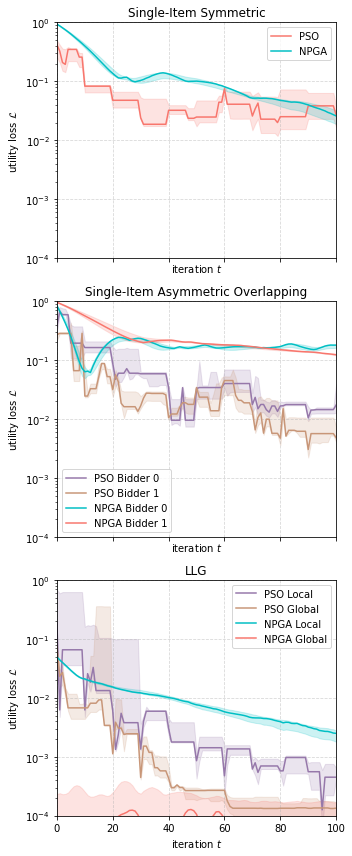

In [103]:
fig, axs = plt.subplots(3,1, sharey=True, sharex=True, figsize=(5, 12))

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

agg = [percentile(25), percentile(75), 'median']

# single-item sym
# pso
color = colors[1]
df = single_item_sym_pso_df
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[0].plot(x, y, '-', label='PSO', color=color)
axs[0].fill_between(x, mi, ma, alpha=.2, color=color)

# npga
color = colors[0]
df = single_item_sym_npga_df
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[0].plot(x, y, '-', label='NPGA', color=color)
axs[0].fill_between(x, mi, ma, alpha=.2, color=color)



# single item asym
# pso bidder0
color = colors[2]
df = single_item_asym_pso_df
df = df[df['subrun'] == 'bidder0']
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[1].plot(x, y, '-', label='PSO Bidder 0', color=color)
axs[1].fill_between(x, mi, ma, alpha=.2, color=color)

# pso bidder1
color = colors[3]
df = single_item_asym_pso_df
df = df[df['subrun'] == 'bidder1']
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[1].plot(x, y, '-', label='PSO Bidder 1', color=color)
axs[1].fill_between(x, mi, ma, alpha=.2, color=color)

# npga bidder0
color = colors[0]
df = single_item_asym_npga_df
df = df[df['subrun'] == 'bidder0']
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[1].plot(x, y, '-', label='NPGA Bidder 0', color=color)
axs[1].fill_between(x, mi, ma, alpha=.2, color=color)

# npga bidder1
color = colors[1]
df = single_item_asym_npga_df
df = df[df['subrun'] == 'bidder1']
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[1].plot(x, y, '-', label='NPGA Bidder 1', color=color)
axs[1].fill_between(x, mi, ma, alpha=.2, color=color)




# LLG
# pso local
color = colors[2]
df = llg_pso_df
df = df[df['subrun'] == 'locals']
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[2].plot(x, y, '-', label='PSO Local', color=color)
axs[2].fill_between(x, mi, ma, alpha=.2, color=color)

# pso global
color = colors[3]
df = llg_pso_df
df = df[df['subrun'] == 'global']
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[2].plot(x, y, '-', label='PSO Global', color=color)
axs[2].fill_between(x, mi, ma, alpha=.2, color=color)

# npga local
color = colors[0]
df = llg_npga_df
df = df[df['subrun'] == 'locals']
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[2].plot(x, y, '-', label='NPGA Local', color=color)
axs[2].fill_between(x, mi, ma, alpha=.2, color=color)


# npga global
color = colors[1]
df = llg_npga_df
df = df[df['subrun'] == 'global']
df_sub = df[df['tag'] == 'eval/epsilon_relative'][['epoch', 'value']]
df_sub = df_sub.groupby('epoch').agg(agg)
df_sub.columns = ['min', 'max', 'mean']
df_sub.head()
x, y, mi, ma = df_sub.index, df_sub['mean'], df_sub['min'], df_sub['max']
axs[2].plot(x, y, '-', label='NPGA Global', color=color)
axs[2].fill_between(x, mi, ma, alpha=.2, color=color)






axs[0].set_title('Single-Item Symmetric')
axs[1].set_title('Single-Item Asymmetric Overlapping')
axs[2].set_title('LLG')
#axs[3].set_title('LLG Full')

# plot
for ax in axs.flat:
    ax.set_yscale('log')
    ax.set_xlim([0, max(x)])
    ax.set_ylim([1e-4, 1e0])
    ax.grid(which='major', alpha=.5, linestyle='--')
    ax.set_xlabel('iteration $t$')
    ax.set_ylabel('utility loss $\mathcal{L}$')
    ax.legend()
plt.tight_layout()
# plt.savefig('learning_progress.pdf', format='pdf')
plt.show()